# XGBoost Parameter Tuning for Otto Dataset

我们以Kaggle 2015年举办的Otto Group Product Classification Challenge竞赛数据为例，进行XGBoost参数调优探索。

竞赛官网：https://www.kaggle.com/c/otto-group-product-classification-challenge/data

# 第二步：调整树的参数：max_depth & min_child_weight
(粗调，参数的步长为2；下一步是在粗调最佳参数周围，将步长降为1，进行精细调整)

In [2]:
import sys
sys.path.append('/mnt/wc/xgboost/python-package')

首先 import 必要的模块

In [3]:
from xgboost import XGBClassifier
import xgboost as xgb

import pandas as pd 
import numpy as np

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import log_loss

from matplotlib import pyplot
import seaborn as sns
%matplotlib inline

## 读取数据

In [4]:
# path to where the data lies
dpath = './data/'
train = pd.read_csv(dpath +"Otto_train.csv")
#train.head()

## Variable Identification

选择该数据集是因为的数据特征单一，我们可以在特征工程方面少做些工作，集中精力放在参数调优上

## Target 分布，看看各类样本分布是否均衡

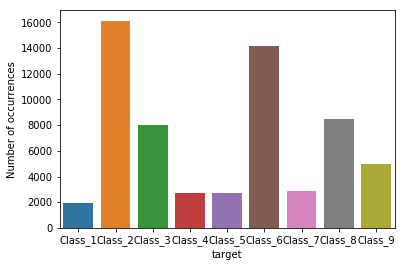

In [5]:
sns.countplot(train.target);
pyplot.xlabel('target');
pyplot.ylabel('Number of occurrences');

每类样本分布不是很均匀，所以交叉验证时也考虑各类样本按比例抽取

In [6]:
# drop ids and get labels
y_train = train['target']
y_train = y_train.map(lambda s: s[6:])
y_train = y_train.map(lambda s: int(s)-1)

train = train.drop(["id", "target"], axis=1)
X_train = np.array(train)

各类样本不均衡，交叉验证是采用StratifiedKFold，在每折采样时各类样本按比例采样

In [7]:
# prepare cross validation
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=3)

第一轮参数调整得到的n_estimators最优值（656），其余参数继续默认值

用交叉验证评价模型性能时，用scoring参数定义评价指标。评价指标是越高越好，因此用一些损失函数当评价指标时，需要再加负号，如neg_log_loss，neg_mean_squared_error 详见sklearn文档：http://scikit-learn.org/stable/modules/model_evaluation.html#log-loss

In [9]:
#max_depth 建议3-10， min_child_weight=1／sqrt(ratio_rare_event) =5.5
max_depth = range(3,10,2)
min_child_weight = range(1,6,2)
param_test2_1 = dict(max_depth=max_depth, min_child_weight=min_child_weight)
param_test2_1

{'max_depth': range(3, 10, 2), 'min_child_weight': range(1, 6, 2)}

In [10]:
xgb2_1 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=2,  #第一轮参数调整得到的n_estimators最优值
        max_depth=5,
        min_child_weight=1,
        gamma=0,
        subsample=0.3,
        colsample_bytree=0.8,
        colsample_bylevel = 0.7,
        objective= 'multi:softprob',
        seed=3,
        tree_method='gpu_hist',
        predictor='gpu_predictor',
        n_jobs= -1)


gsearch2_1 = GridSearchCV(xgb2_1, param_grid = param_test2_1, scoring='neg_log_loss',n_jobs=-1, cv=kfold)
gsearch2_1.fit(X_train , y_train)

gsearch2_1.grid_scores_, gsearch2_1.best_params_,     gsearch2_1.best_score_

/mnt/wc/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: -1.88501, std: 0.00140, params: {'max_depth': 3, 'min_child_weight': 1},
  mean: -1.88531, std: 0.00126, params: {'max_depth': 3, 'min_child_weight': 3},
  mean: -1.88592, std: 0.00164, params: {'max_depth': 3, 'min_child_weight': 5},
  mean: -1.83834, std: 0.00162, params: {'max_depth': 5, 'min_child_weight': 1},
  mean: -1.83959, std: 0.00152, params: {'max_depth': 5, 'min_child_weight': 3},
  mean: -1.84091, std: 0.00165, params: {'max_depth': 5, 'min_child_weight': 5},
  mean: -1.82155, std: 0.00293, params: {'max_depth': 7, 'min_child_weight': 1},
  mean: -1.82468, std: 0.00299, params: {'max_depth': 7, 'min_child_weight': 3},
  mean: -1.82773, std: 0.00261, params: {'max_depth': 7, 'min_child_weight': 5},
  mean: -1.79372, std: 0.00692, params: {'max_depth': 9, 'min_child_weight': 1},
  mean: -1.80050, std: 0.00389, params: {'max_depth': 9, 'min_child_weight': 3},
  mean: -1.80346, std: 0.00415, params: {'max_depth': 9, 'min_child_weight': 5}],
 {'max_depth': 9, 'min_chil

In [11]:
gsearch2_1.cv_results_

/mnt/wc/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/mnt/wc/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/mnt/wc/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/mnt/wc/anac

{'mean_fit_time': array([1.94509964, 1.14265275, 0.95750818, 1.08654346, 0.97046285,
        0.87321191, 1.25502439, 1.23530412, 1.14519162, 1.70256109,
        1.6405673 , 1.21747994]),
 'mean_score_time': array([0.04708824, 0.02914495, 0.05214548, 0.04472122, 0.03689756,
        0.02117233, 0.04225488, 0.04044294, 0.0354785 , 0.030159  ,
        0.03538175, 0.0199369 ]),
 'mean_test_score': array([-1.88500701, -1.8853125 , -1.88591616, -1.83834477, -1.83958888,
        -1.84091349, -1.82155469, -1.82467932, -1.8277282 , -1.79372056,
        -1.80050243, -1.80346464]),
 'mean_train_score': array([-2.1756323 , -2.11689326, -2.11741279, -2.17750071, -2.17741945,
        -2.17749322, -2.17832669, -2.17828165, -2.10730634, -2.17995286,
        -2.10417377, -2.17965316]),
 'param_max_depth': masked_array(data=[3, 3, 3, 5, 5, 5, 7, 7, 7, 9, 9, 9],
              mask=[False, False, False, False, False, False, False, False,
                    False, False, False, False],
        fill_value='

Best: -1.793721 using {'max_depth': 9, 'min_child_weight': 1}


/mnt/wc/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/mnt/wc/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('std_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/mnt/wc/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/mnt/wc/anacond

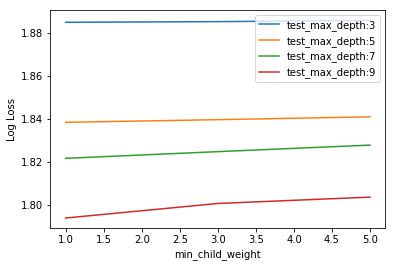

In [12]:
# summarize results
print("Best: %f using %s" % (gsearch2_1.best_score_, gsearch2_1.best_params_))
test_means = gsearch2_1.cv_results_[ 'mean_test_score' ]
test_stds = gsearch2_1.cv_results_[ 'std_test_score' ]
train_means = gsearch2_1.cv_results_[ 'mean_train_score' ]
train_stds = gsearch2_1.cv_results_[ 'std_train_score' ]

pd.DataFrame(gsearch2_1.cv_results_).to_csv('my_preds_maxdepth_min_child_weights_1.csv')

# plot results
test_scores = np.array(test_means).reshape(len(max_depth), len(min_child_weight))
train_scores = np.array(train_means).reshape(len(max_depth), len(min_child_weight))

for i, value in enumerate(max_depth):
    pyplot.plot(min_child_weight, -test_scores[i], label= 'test_max_depth:'   + str(value))
#for i, value in enumerate(min_child_weight):
#    pyplot.plot(max_depth, train_scores[i], label= 'train_min_child_weight:'   + str(value))
    
pyplot.legend()
pyplot.xlabel( 'min_child_weight' )                                                                                                      
pyplot.ylabel( 'Log Loss' )
pyplot.savefig('max_depth_vs_min_child_weght_1.png' )